In [26]:
import pandas as pd
import numpy as np

In [27]:
df = pd.read_csv('T1.csv')

In [28]:
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [30]:
df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [31]:
print(df.isnull().sum())
print('-' * 50)
print(f"duplicated rows : {df.duplicated().sum()}")

Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64
--------------------------------------------------
duplicated rows : 0


In [32]:
df = df.rename(columns={
    'Date/Time': 'datetime',
    'LV ActivePower (kW)': 'actual_power_kw',
    'Wind Speed (m/s)': 'wind_speed_ms',
    'Theoretical_Power_Curve (KWh)': 'theoretical_power_kw',
    'Wind Direction (°)': 'wind_direction_deg'
})

print(df.head())

           datetime  actual_power_kw  ...  theoretical_power_kw  wind_direction_deg
0  01 01 2018 00:00       380.047791  ...            416.328908          259.994904
1  01 01 2018 00:10       453.769196  ...            519.917511          268.641113
2  01 01 2018 00:20       306.376587  ...            390.900016          272.564789
3  01 01 2018 00:30       419.645905  ...            516.127569          271.258087
4  01 01 2018 00:40       380.650696  ...            491.702972          265.674286

[5 rows x 5 columns]


In [33]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%d %m %Y %H:%M')

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

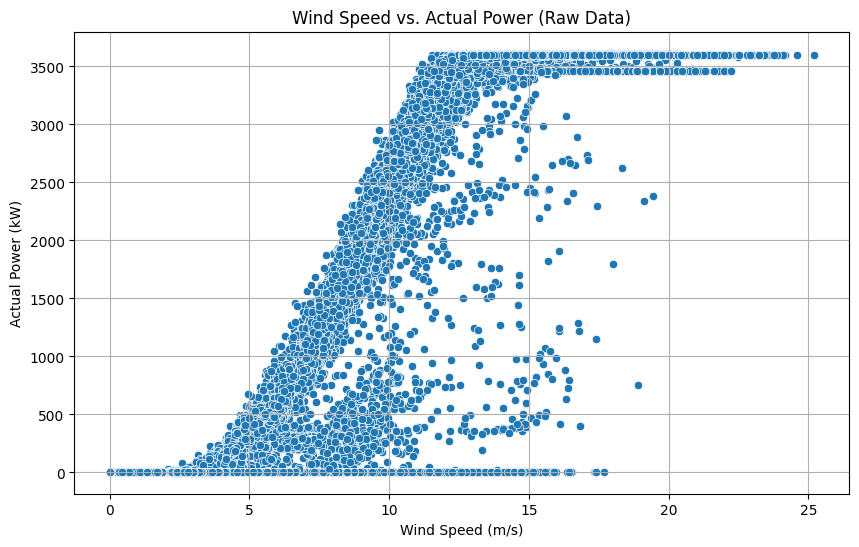

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind_speed_ms', y='actual_power_kw', data=df)
plt.title('Wind Speed vs. Actual Power (Raw Data)')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Actual Power (kW)')
plt.grid(True)
plt.show()

In [36]:
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df = df.dropna(subset=['datetime'])

df = df.drop_duplicates(subset=['datetime'])

df = df[df['actual_power_kw'] >= 0]
df = df[df['wind_speed_ms'] >= 0]
df = df[df['theoretical_power_kw'] >= 0]

df_cleaned = df.copy()

# Remove rows where wind=0 but power>0
df_cleaned = df[~((df['wind_speed_ms'] == 0) & (df['actual_power_kw'] > 0))]

# Remove rows where wind>2 but power=0 (turbine off / error)
df_cleaned = df_cleaned[~((df_cleaned['wind_speed_ms'] > 2) & (df_cleaned['actual_power_kw'] == 0))]


In [37]:
df_cleaned['hour'] = df_cleaned['datetime'].dt.hour
df_cleaned['month'] = df_cleaned['datetime'].dt.month


df_cleaned['hour_sin'] = np.sin((2 * np.pi * df_cleaned['hour'] / 24))
df_cleaned['hour_cos'] = np.cos((2 * np.pi * df_cleaned['hour'] / 24))
df_cleaned['month_sin'] = np.sin((2 * np.pi * df_cleaned['month'] / 12))
df_cleaned['month_cos'] = np.cos((2 * np.pi * df_cleaned['month'] / 12))

df_cleaned = df_cleaned.drop(columns=['hour', 'month'])

In [38]:
df_cleaned.to_csv('T1_cleaned.csv', index=False)

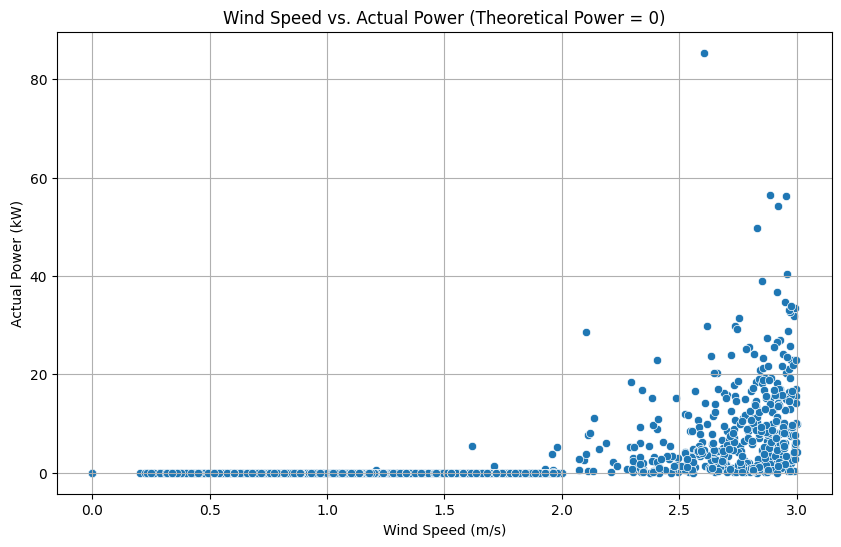

In [39]:
subset = df_cleaned[df_cleaned['theoretical_power_kw'] == 0]
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind_speed_ms', y='actual_power_kw', data=subset)
plt.title('Wind Speed vs. Actual Power (Theoretical Power = 0)')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Actual Power (kW)')
plt.grid(True)
plt.show()

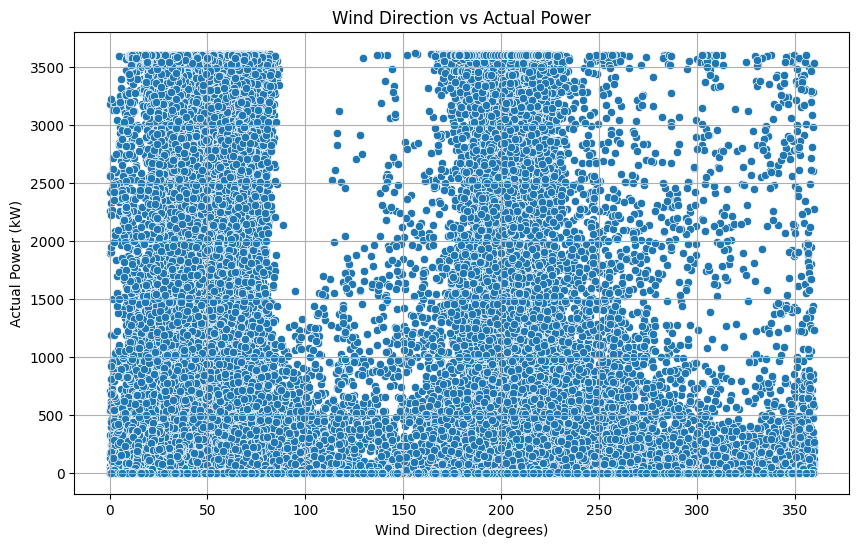

In [40]:
plt.figure(figsize = (10,6))
sns.scatterplot(x = "wind_direction_deg", y = "actual_power_kw", data = df_cleaned)
plt.title("Wind Direction vs Actual Power")
plt.xlabel("Wind Direction (degrees)")
plt.ylabel("Actual Power (kW)")
plt.grid(True)
plt.show()

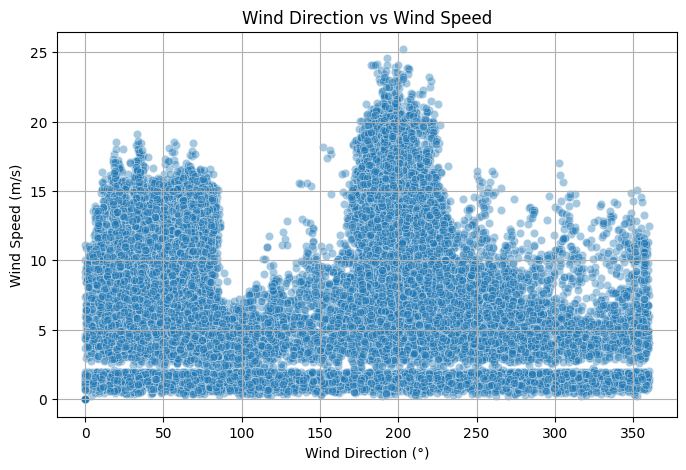

In [41]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x='wind_direction_deg',
    y='wind_speed_ms',
    data=df_cleaned,
    alpha=0.4
)
plt.title('Wind Direction vs Wind Speed')
plt.xlabel('Wind Direction (°)')
plt.ylabel('Wind Speed (m/s)')
plt.grid(True)
plt.show()

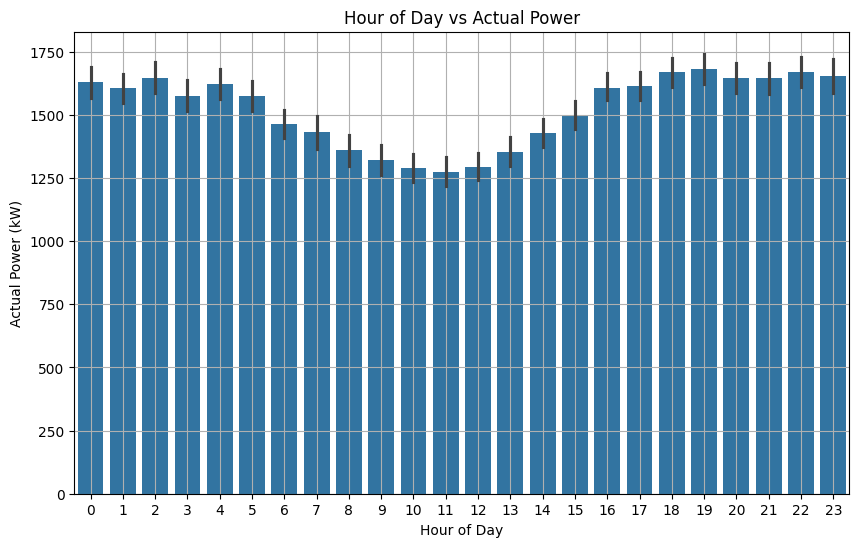

In [42]:
plt.figure(figsize = (10,6))
sns.barplot(x=df_cleaned['datetime'].dt.hour, y=df_cleaned['actual_power_kw'], estimator= np.mean)
plt.title("Hour of Day vs Actual Power")
plt.xlabel("Hour of Day")
plt.ylabel("Actual Power (kW)")
plt.grid(True)
plt.show()

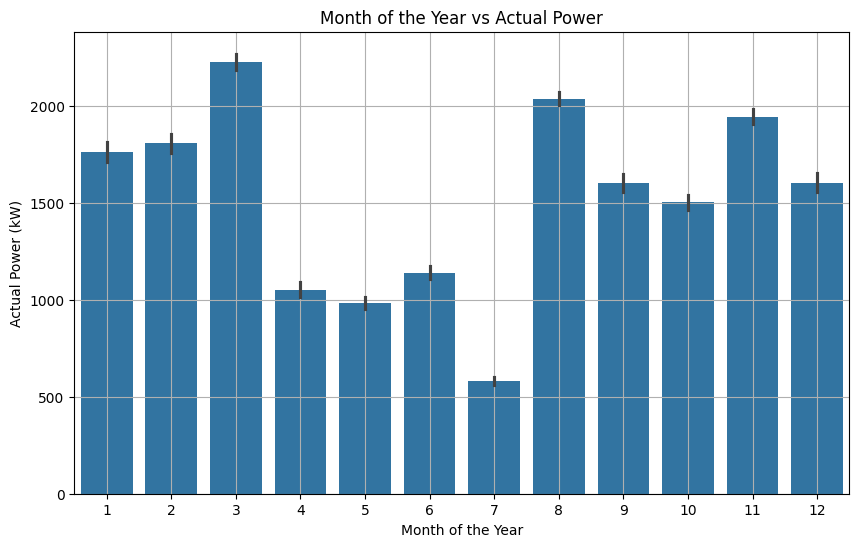

In [43]:
plt.figure(figsize = (10,6))
sns.barplot(x=df_cleaned['datetime'].dt.month, y=df_cleaned['actual_power_kw'], estimator= np.mean)
plt.title("Month of the Year vs Actual Power")
plt.xlabel("Month of the Year")
plt.ylabel("Actual Power (kW)")
plt.grid(True)
plt.show()

In [44]:
df.columns

Index(['datetime', 'actual_power_kw', 'wind_speed_ms', 'theoretical_power_kw',
       'wind_direction_deg'],
      dtype='object')

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = df_cleaned[['wind_speed_ms', 'wind_direction_deg', 'theoretical_power_kw',
                'hour_sin', 'hour_cos', 'month_sin', 'month_cos']]
y = df_cleaned['actual_power_kw']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)